In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from scipy import stats
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 512
nTime = nLat
nTimemultiplier1 = 2
nTimemultiplier2 = 10

nSims = 100

phi0 = 1.
m2bare = 1.
lenLat = 100.
nCols = 2

nyq = nLat//2
spec = nyq

alpha = 8
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

### Theoretical Field PS 

In [109]:
sim_location = lambda nT, nL, gam, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_t'+str(nT)+'_x'+str(nL)+'_gam'+str(gam)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, gam, m2, tem, phi, lam, sim):
    nTT = nT*(nTimemultiplier1 if gam != 1 else nTimemultiplier2)
    data = np.genfromtxt(sim_location(nTT, nL, gam, m2, tem, phi, lam, sim))
    return np.asarray([np.reshape(data[:,col], (nTT, nL))[-nL:] for col in range(nCols)])

In [110]:
# field spectrum
# prediction from lattice renormalization
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
norm = 1./ phi0 / np.sqrt(2.*lenLat)
omega = np.sqrt(freqs**2. + m2bare)

spectral_field = lambda tem: np.asarray([norm * np.sqrt(2./(np.exp(omega[k]/tem) - 1.)) / omega[k]**0.5 if k != nLat//2 else 0 for k in range(nLat)])
sigma0sq_th = lambda tem: np.sum( np.abs(spectral_field(tem))**2. )

V = lambda x, lam: -0.5*m2bare*x**2. + lam*x**4./24.
Vdoubleprime = lambda x, lam: -m2bare + 0.5*lam*x**2.

In [111]:
def turning_points(array):
    ''' turning_points(array) -> min_indices, max_indices
    Finds the turning points within an 1D array and returns the indices of the minimum and 
    maximum turning points in two separate lists.
    '''
    idx_max, idx_min = [], []
    if (len(array) < 3): 
        return idx_min, idx_max

    NEUTRAL, RISING, FALLING = range(3)
    def get_state(a, b):
        if a < b: return RISING
        if a > b: return FALLING
        return NEUTRAL

    ps = get_state(array[0], array[1])
    begin = 1
    for i in range(2, len(array)):
        s = get_state(array[i - 1], array[i])
        if s != NEUTRAL:
            if ps != NEUTRAL and ps != s:
                if s == FALLING: 
                    idx_max.append((begin + i - 1) // 2)
                else:
                    idx_min.append((begin + i - 1) // 2)
            begin = i
            ps = s
    return np.asarray(idx_min), np.asarray(idx_max)

curvatures =  [array([2.0000066, 2.0000066]) array([-1.])]


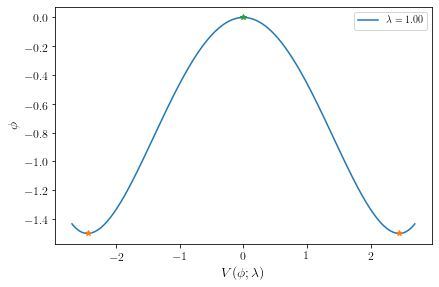

In [112]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))
lamb = 1.
xlist = np.linspace(-1.1*np.sqrt(6*m2bare/lamb), 1.1*np.sqrt(6*m2bare/lamb), 1000000)
minima, maxima = turning_points(V(xlist, lamb))
minima, maxima = xlist[minima], xlist[maxima]

plt.plot(xlist, V(xlist, lamb), label=f'$\lambda = %5.2f$'%(lamb))
plt.plot(minima, V(minima, lamb), marker='*', linestyle='None')
plt.plot(maxima, V(maxima, lamb), marker='*', linestyle='None')

curvatures = np.asarray([Vdoubleprime(minima, lamb), Vdoubleprime(maxima, lamb)])
print('curvatures = ', curvatures)

plt.xlabel(f'$V(\phi; \lambda)$')
plt.ylabel(f'$\phi$')
plt.legend()
plt.show()

### Extract data from files

In [8]:
list_temp = np.arange(1, 16, 1)[::4]; print(list_temp)
list_lamb = [1.]
list_gamma = [0, 1]

all_free_data = np.asarray([[[[[extract_sim(nTime, nLat, gamma, m2bare, temp, phi0, lamb, sim) for sim in range(nSims)] for lamb in list_lamb] for gamma in list_gamma[:1]] for temp in list_temp]])
print('Done')

all_int_data = np.asarray([[[[[extract_sim(nTime, nLat, gamma, m2bare, temp, phi0, lamb, sim) for sim in range(nSims)] for lamb in list_lamb] for gamma in list_gamma[1:]] for temp in list_temp]])
print('Done')

all_data = [all_free_data, all_int_data]

[ 1  5  9 13]
Done
Done


In [9]:
for ind, data in enumerate(all_data):
    for lll, lamb in enumerate(list_lamb):
        print('lamb = ', lamb)
        print(sigma0sq_th(list_temp).tolist())
        print([np.mean(all_data[ind][0][ttt][0][lll][:,0,0]**2.) for ttt in range(len(list_temp))])

lamb =  1.0
[0.180837836831247, 1.884420348519045, 3.7310402619151954, 5.5979640818079375]
[0.17411107755313956, 1.6371285813248135, 3.065908636183504, 4.3574520875689755]
lamb =  1.0
[0.180837836831247, 1.884420348519045, 3.7310402619151954, 5.5979640818079375]
[5.133724513129772, 3.608554560641132, 3.982857965550313, 4.8906390408635785]


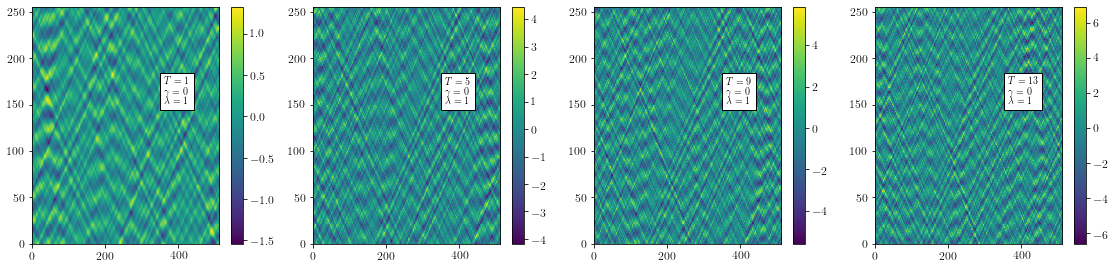

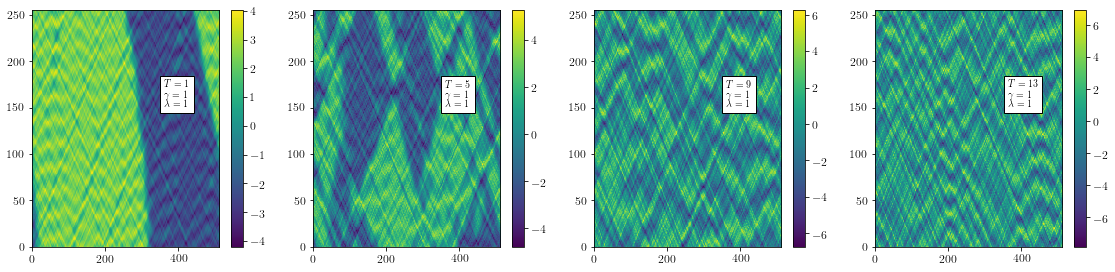

In [113]:
if True:
    sim = random.randint(0, nSims-1)

    for ind in range(len(all_data)):
        for lll, lamb in enumerate(list_lamb):
            fig, ax = plt.subplots(1, len(list_temp), figsize = (5*len(list_temp), 4))
            for ttt, temp in enumerate(list_temp):
                im0 = ax[ttt].imshow(all_data[ind][0][ttt][lll][0][sim][0], aspect='auto', interpolation='none', origin='lower')
                clb = plt.colorbar(im0, ax = ax[ttt])
                ax[ttt].text(nLat-150, 150, f'$T = %5.0f$\n$\gamma = %5.0f$\n$\lambda = %5.0f$'%(temp, list_gamma[ind], lamb), bbox={'facecolor': 'white', 'pad': 4})
            plt.show()

In [118]:
def get_truncation_frequency(PowSpec, thresh):
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
    pick_freq_window = (kk>0)&(kk<thresh)
    window_in_k = np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(oo>0)&(oo<=max(kk))] # here oo becomes kk
    minpeaks, properties = scs.find_peaks(-window_in_k, height=-max(window_in_k))
    try:
        if window_in_k[1]-window_in_k[0]>0: # basically here there are no walls, the PS is scrictly ascending at low k
            raise ValueError
        peak = minpeaks[0]
        height = -properties['peak_heights'][minpeaks==peak][0]
    except (ValueError, IndexError):
        peak = 0
        height = window_in_k[peak]
    return [peak, height]

def get_pspec(data, lll, ggg, ttt, thresh):
    PowSpec = np.mean([np.abs(np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][sim][0])))**2. for sim in range(nSims)], axis=0)
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi

    pick_freq_window = (kk>0)&(kk<thresh)
#    print('averaged ks', kk[kk==pick_freq_window])
    pick_omega = np.sort(oo[oo>0])[0]
    return PowSpec, np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)], PowSpec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]

In [129]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses(ind, data, bool, bool2, multiplier, lll, lamb, ggg):
    masses = []
    if bool2: fig, ax = plt.subplots(1, len(list_temp), figsize = (6*len(list_temp), 4))
    for ttt, temp in enumerate(list_temp):
        PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][:,0])))**2., axis=0)
        PowSpec2plot = PowSpec

        kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)
        
        if ind == 0:
            osccoords = np.argwhere(PowSpec > np.mean(PowSpec) + multiplier * np.std(PowSpec))
        else:
            trunc_freq, trunc_amp = get_truncation_frequency(PowSpec, thresh)
            PowSpec = PowSpec*(np.abs(OO) >= oo[oo>0][trunc_freq])
            osccoords = np.argwhere(PowSpec > min(trunc_amp, np.mean(PowSpec) + multiplier * np.std(PowSpec) ))

        popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
        if popt[-1] < 0: masses.append('nan')
        else: masses.append(popt[-1])

        if bool2:
            lim = 5
            kk2plot = kk[(0<=kk)&(kk<=lim)]
            oo2plot = oo[(0<=oo)&(oo<=lim)]
            PowSpec2plot = PowSpec2plot[:, (0<=kk)&(kk<=lim)][(0<=oo)&(oo<=lim)]
            ax[ttt].plot(kk, np.sqrt(omega_fit(kk, np.abs(curvatures[0][0]))), color = 'purple', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(np.abs(curvatures[0][0])))
            ax[ttt].plot(kk, np.sqrt(omega_fit(kk, np.abs(curvatures[1][0]))), color = 'r', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(np.abs(curvatures[1][0])))
            ax[ttt].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'orange', ls='-', label=f'$m^2 = %5.2f$'%(popt[-1]))
            
            exts = [kk2plot[0],kk2plot[-1],oo2plot[0],oo2plot[-1]]
            im = ax[ttt].imshow(np.log(np.sqrt(PowSpec2plot)), aspect='auto', interpolation='none', origin='lower', extent=exts)
            clb = plt.colorbar(im, ax = ax[ttt])
            clb.set_label(r'$\log{\sqrt{|\phi_k|^2}}$')
            ax[ttt].set_xlabel(r'$\bar{k}$')
            ax[ttt].set_ylabel(r'$\bar{\omega_k}$')
            [axx.set_xlim(0,kk2plot[-1]) for axx in ax]
            [axx.set_ylim(0,oo2plot[-1]) for axx in ax]
            ax[ttt].legend(title=r'$T = %5.0f, \lambda = %5.0f$'%(temp, lamb))
            
        if bool:
            lim = max(freqs)
            fig, ax = plt.subplots(1, 2, figsize = (16, 4))
            kk2plot = kk[(0<=kk)&(kk<=lim)]
            oo2plot = oo[(0<=oo)&(oo<=lim)]
            ax[0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$T = %5.5f, m^2 = %5.5f$'%(temp, popt[-1]))
            ax[0].set_xlim(0,kk2plot[-1])
            ax[0].set_ylim(0,oo2plot[-1])
            ax[0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2bare, color='darkgray', ls='-.', label='potential mass')
            ax[0].legend()

            lim = 3
            kk2plot = kk[(0<=kk)&(kk<=lim)]
            oo2plot = oo[(0<=oo)&(oo<=lim)]
            PowSpec2plot = PowSpec2plot[:, (0<=kk)&(kk<=lim)][(0<=oo)&(oo<=lim)]
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', ls=':', label=f'$m^2 = %5.2f$'%(popt[-1]))
            ax[1].plot(kk, np.sqrt(omega_fit(kk, np.abs(curvatures[0][0]))), color = 'purple', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(np.abs(curvatures[0][0])))
            ax[1].plot(kk, np.sqrt(omega_fit(kk, np.abs(curvatures[1][0]))), color = 'r', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(np.abs(curvatures[1][0])))
            exts = [kk2plot[0],kk2plot[-1],oo2plot[0],oo2plot[-1]]
            im = ax[1].imshow(np.log(PowSpec2plot), aspect='auto', interpolation='none', origin='lower', extent=exts)
            clb = plt.colorbar(im, ax = ax[1])
            clb.set_label(r'$\log{\sqrt{|\phi_k|^2}}$')
            ax[1].set_xlabel(r'$\bar{k}$')
            ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].set_xlim(0,kk2plot[-1])
            ax[1].set_ylim(0,oo2plot[-1])
            [i.legend(f'$T = %5.2f, \lambda = %5.2f$'%(temp, lamb)) for i in ax]
            plt.show()
    return masses

In [130]:
multiplier = 10
thresh = 0.1

if False:
    for ind, data in enumerate(all_data):
        fig, ax = plt.subplots(1, 2, figsize = (15,4))
        colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
        for lll, lamb in enumerate(list_lamb):
            for ttt, temp in enumerate(list_temp):
                col = next(colors)
                list_time = np.arange(len(data[0][ttt][lll][0][0,0]))

                list_m2eff = [(-m2bare if ind==1 else m2bare) + 0.5*lamb*np.mean(data[0][ttt][lll][0][:,0,time]**2.) for time in list_time]
                ax[0].plot(list_time, list_m2eff, color=col, label='T='+str(temp))
                ax[0].axhline((-m2bare if ind==1 else m2bare) + 0.5*lamb*sigma0sq_th(temp), linestyle=':', color=col)

                mnfld = [np.mean(data[0][ttt][lll][0][:,0,time]) for time in list_time]
                ax[1].plot(list_time, mnfld, color=col, label='T='+str(temp))

            ax[0].set_ylabel(r'$m_{\mathrm{eff}}^2$')
            ax[1].set_ylabel(r'$<\phi>$')
            for axx in ax:
                axx.legend(title=r'$\lambda = %5.0f$'%(lamb))
                axx.grid(color='darkgray', linestyle='-', linewidth=0.2)
                axx.set_xlabel(f'$t$')
        plt.tight_layout()
        plt.show()

### Get profile of omega ^2

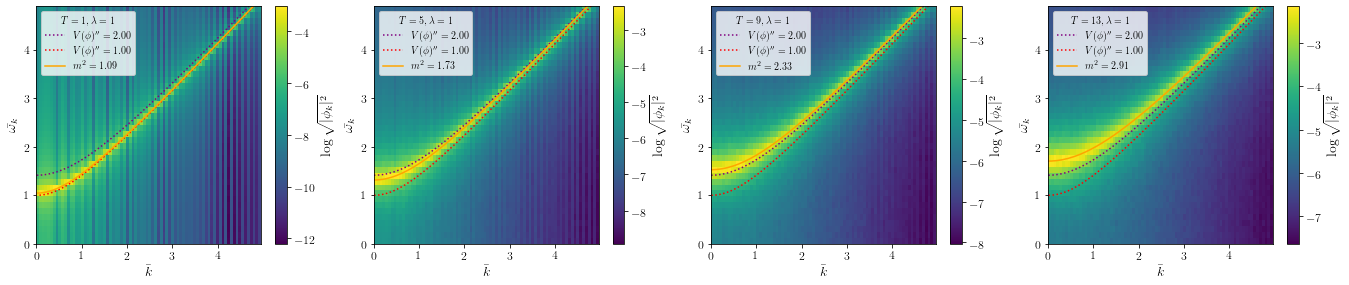

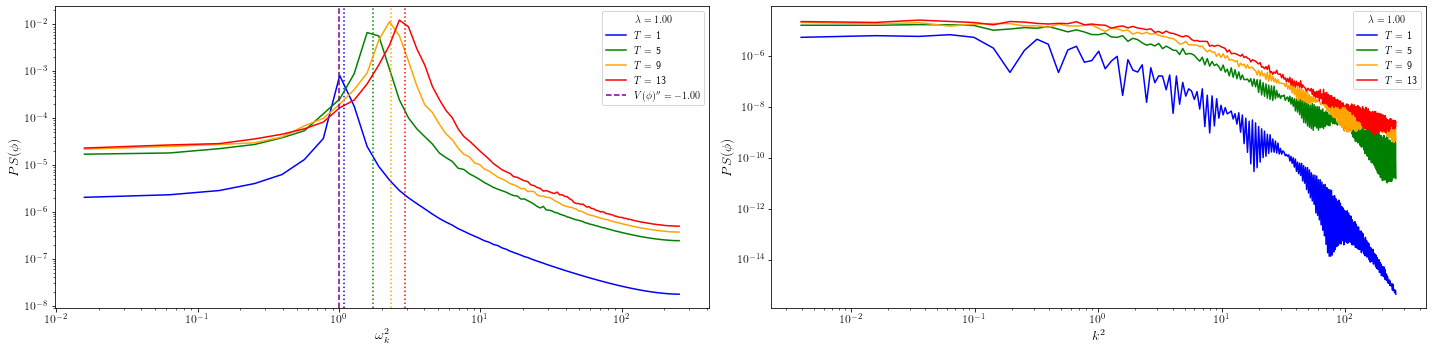

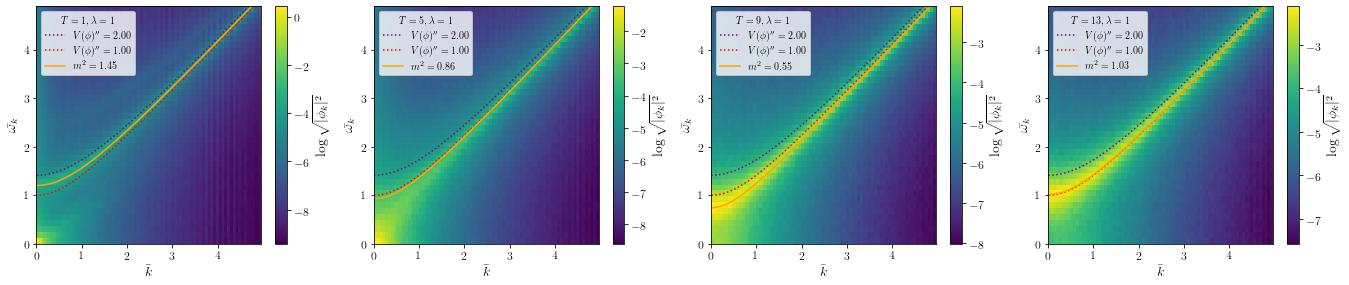

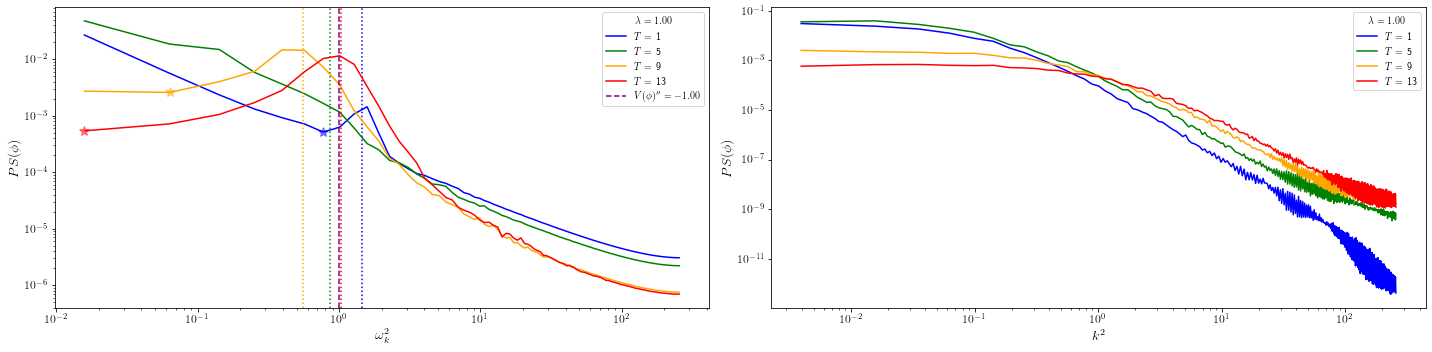

In [131]:
if True:
    for ind, data in enumerate(all_data):
        for lll, lamb in enumerate(list_lamb):
            data_mass = get_masses(ind, data[0], False, True, multiplier, lll, lamb, 0)

            colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
            fig, ax = plt.subplots(1, 2, figsize = (20, 5))
            for ttt, temp in enumerate(list_temp):
                col = next(colors)

                pspec, window_in_k, fix_omega, oo, kk = get_pspec(data[0], lll, 0, ttt, thresh)
                peak, height = get_truncation_frequency(pspec, thresh)
                if ind != 0 and ttt != 1:
                    ax[0].plot(oo[peak]**2., height, "*", color=col, ms=10, alpha=0.5)
                ax[0].plot(oo**2., window_in_k, label=f'$T$ = '+str(temp), color=col)
                ax[1].plot(kk**2., fix_omega, label=f'$T$ = '+str(temp), color=col)

                ax[0].set_xlabel(f'$\omega_k^2$')
                ax[1].set_xlabel(f'$k^2$')

                ax[0].axvline(data_mass[ttt], color=col, ls=':')

#            ax[0].axvline(curvatures[0][0], color='purple', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(curvatures[0][0]))
            ax[0].axvline(np.abs(curvatures[1][0]), color='purple', ls='--', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(curvatures[1][0]))

            for ii in ax:
                ii.set_xscale('log')
                ii.set_yscale('log')
                ii.set_ylabel(f'$PS(\phi)$')
                ii.legend(title=f'$\lambda = %5.2f$'%(lamb))
            plt.tight_layout()
            plt.show()

# Separate Real and Imaginary Contributions to PSwindow_in_k

In [127]:
def get_masses_seps(ind, data, bool, multiplier, lll, lamb, ggg, thresh):
    fullmasses, remasses, immasses = [], [], []
    for ttt, temp in enumerate(list_temp):
        fullPowSpec, rePowSpec, imPowSpec = [], [], []
        for sim in range(nSims):
            fftfield = np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][sim][0]))
            fullPowSpec.append(np.abs(fftfield)**2.)
            rePowSpec.append(np.abs(fftfield.real)**2.)
            imPowSpec.append(np.abs(fftfield.imag)**2.)
        fullPowSpec, rePowSpec, imPowSpec = np.mean(fullPowSpec, axis = 0), np.mean(rePowSpec, axis = 0), np.mean(imPowSpec, axis = 0)
        fullPowSpec2plot, rePowSpec2plot, imPowSpec2plot = fullPowSpec, rePowSpec, imPowSpec
        
        T, N = np.shape(fullPowSpec)
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)

        full_trunc_freq, full_trunc_amp = get_truncation_frequency(fullPowSpec, thresh)
        re_trunc_freq, re_trunc_amp = get_truncation_frequency(rePowSpec, thresh)
        im_trunc_freq, im_trunc_amp = get_truncation_frequency(imPowSpec, thresh)

        fullPowSpec = fullPowSpec*(np.abs(OO) >= oo[oo>0][full_trunc_freq])
        rePowSpec = rePowSpec*(np.abs(OO) >= oo[oo>0][re_trunc_freq])
        imPowSpec = imPowSpec*(np.abs(OO) >= oo[oo>0][im_trunc_freq])

        if ind == 0:
            fullosccoords = np.argwhere(fullPowSpec > max(full_trunc_amp, np.mean(fullPowSpec) + multiplier * np.std(fullPowSpec)))
            reosccoords = np.argwhere(rePowSpec > max(re_trunc_amp, np.mean(rePowSpec) + multiplier * np.std(rePowSpec)))
            imosccoords = np.argwhere(imPowSpec > max(im_trunc_amp, np.mean(imPowSpec) + multiplier * np.std(imPowSpec)))
        else:
            fullosccoords = np.argwhere(fullPowSpec > min(full_trunc_amp, np.mean(fullPowSpec) + multiplier * np.std(fullPowSpec)))
            reosccoords = np.argwhere(rePowSpec > min(re_trunc_amp, np.mean(rePowSpec) + multiplier * np.std(rePowSpec)))
            imosccoords = np.argwhere(imPowSpec > min(im_trunc_amp, np.mean(imPowSpec) + multiplier * np.std(imPowSpec)))            

        fullmasses.append(sco.curve_fit(omega_fit, kk[fullosccoords[:,1]], oo[fullosccoords[:,0]]**2.)[0])
        remasses.append(sco.curve_fit(omega_fit, kk[reosccoords[:,1]], oo[reosccoords[:,0]]**2.)[0])
        immasses.append(sco.curve_fit(omega_fit, kk[imosccoords[:,1]], oo[imosccoords[:,0]]**2.)[0])

        coords = np.asarray([fullosccoords, reosccoords, imosccoords])
        PowSpecs2Plot = np.asarray([fullPowSpec2plot, rePowSpec2plot, imPowSpec2plot])
        allMasses = np.asarray([fullmasses, remasses, immasses])
        title = ['Full, ', 'Real, ', 'Imag, ']
        if bool:
            fig, ax = plt.subplots(1, len(allMasses), figsize = (20, 4))
            for iii, masses in enumerate(allMasses):
                lim = 5
                kk2plot = kk[(0<=kk)&(kk<=lim)]
                oo2plot = oo[(0<=oo)&(oo<=lim)]
                powspec2plot = PowSpecs2Plot[iii][:, (0<=kk)&(kk<=lim)][(0<=oo)&(oo<=lim)]

                ax[iii].plot(kk[coords[iii][:,1]], oo[coords[iii][:,0]], 'o', ms=5)
                ax[iii].plot(kk, np.sqrt(omega_fit(kk,masses[-1])), color = 'r', linestyle=':', label=f'$m^2 = %5.2f$'%(masses[-1]))
                exts = [kk2plot[0],kk2plot[-1],oo2plot[0],oo2plot[-1]]
                im = ax[iii].imshow(np.log(np.sqrt(powspec2plot)), aspect='auto', interpolation='none', origin='lower', extent=exts)
                clb = plt.colorbar(im, ax = ax[iii])
                clb.set_label(r'$\log{\sqrt{|\phi_k|^2}}$')

            for opp in ax:
                opp.set_xlabel(r'$\bar{k}$')
                opp.set_ylabel(r'$\bar{\omega_k}$')
                opp.set_xlim(0,kk2plot[-1])
                opp.set_ylim(0,oo2plot[-1])
                opp.legend(loc='upper center')
            plt.show()
    return allMasses

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


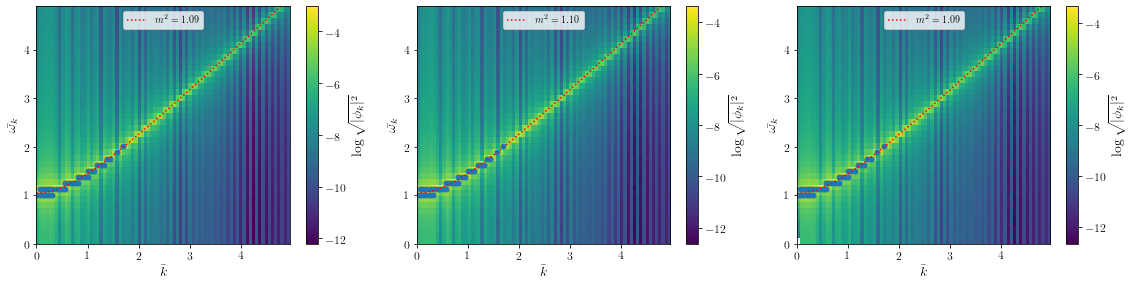

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


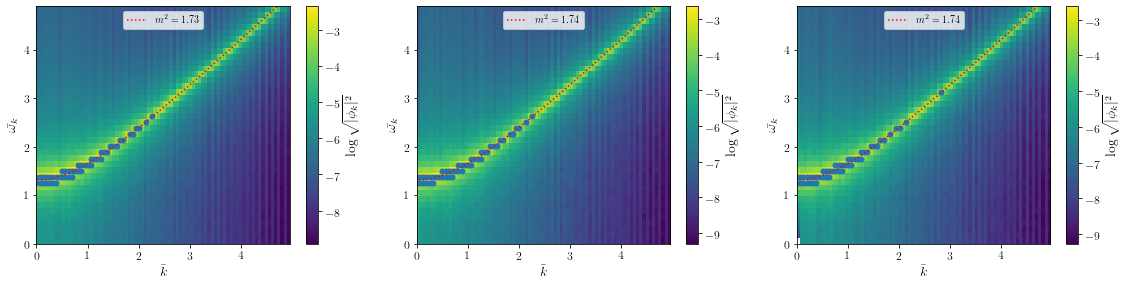

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


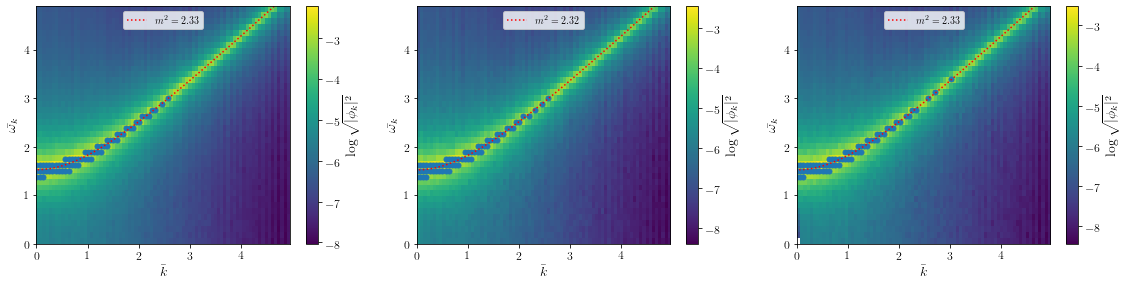

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


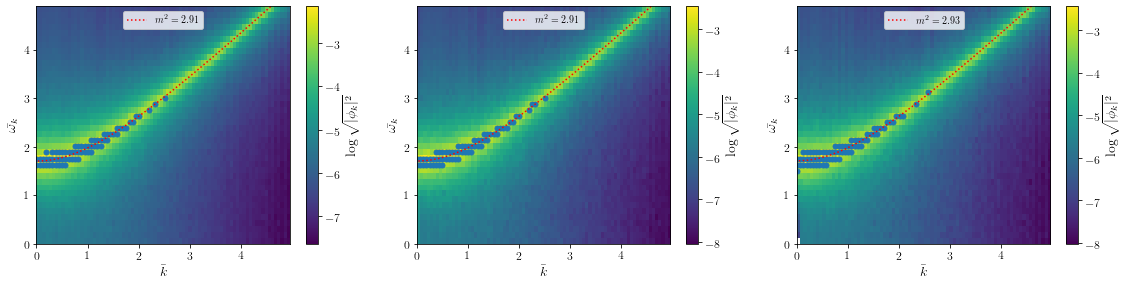

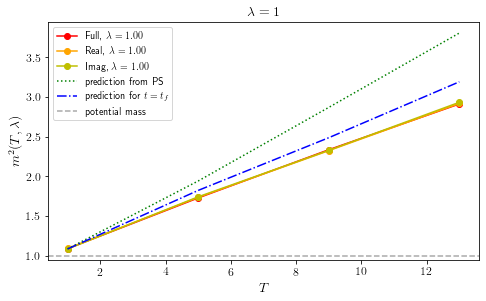

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


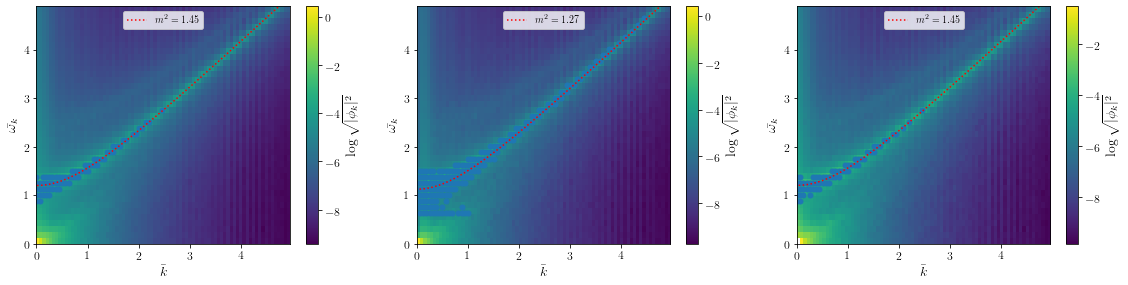

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


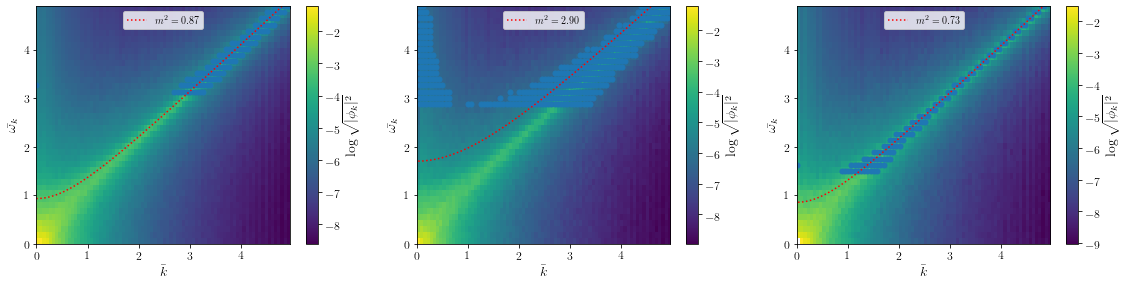

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


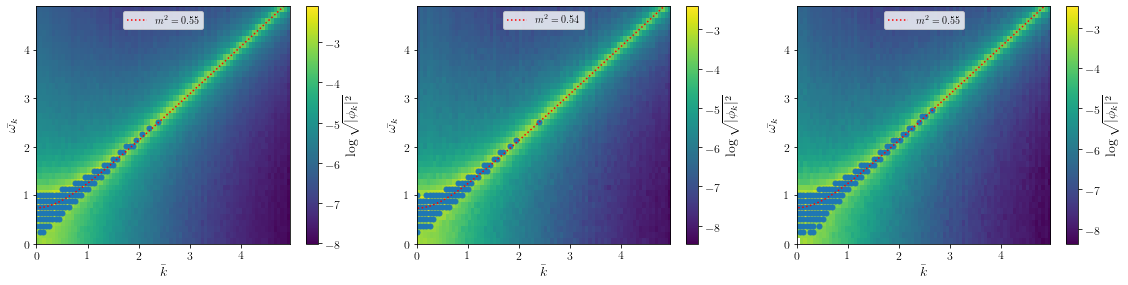

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


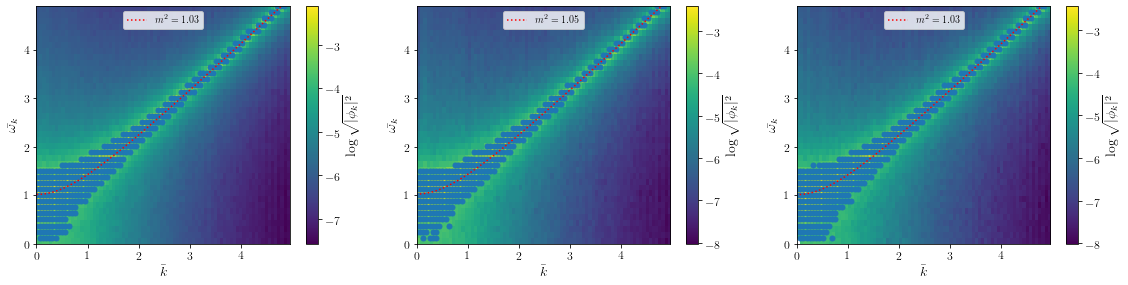

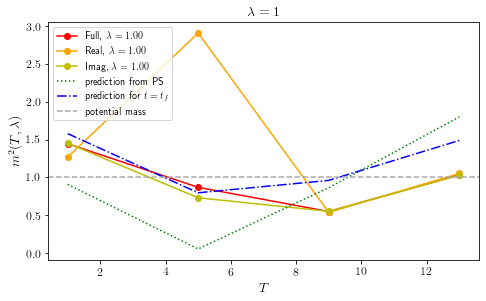

In [128]:
multiplier = 10
thresh = 0.1

if True:
    for ind, data in enumerate(all_data):
        for lll, lamb in enumerate(list_lamb):
            allMasses = get_masses_seps(ind, data[0], True, multiplier, lll, lamb, 0, thresh)

            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            colors = cycle(('r', 'orange', 'y', 'g', 'b', 'm'))
            title = ['Full, ', 'Real, ', 'Imag, ']
            for iii, masses in enumerate(allMasses):
                plt.plot(list_temp, masses, marker='o', linestyle='-', color=next(colors), label=title[iii]+f'$\lambda = %5.2f$'%(lamb))

            for ijk in [ax]:
                ijk.plot(list_temp, np.abs((-m2bare if ind==1 else m2bare) + 0.5*lamb*sigma0sq_th(list_temp)), ':', color=next(colors), label='prediction from PS')
                list_m2_eff_at_nTime = np.abs(np.asarray([(-m2bare if ind==1 else m2bare) + 0.5*lamb*np.mean(data[0][ttt][lll][0][:,0,-1]**2.) for ttt in range(len(list_temp))]))
                ijk.plot(list_temp, list_m2_eff_at_nTime, color=next(colors), linestyle='-.', label='prediction for $t=t_f$')

                ijk.axhline(m2bare, color='darkgray', ls='--', label='potential mass')
                ijk.set_title(f'$\lambda = %5.0f$'%(lamb))
                ijk.set_ylabel(f'$m^2(T, \lambda)$')
                ijk.set_xlabel(f'$T$')
                ijk.legend()
            plt.show()